# Adding lat, long, and country code using geonamescache

**Objective**
Add latitude, longitude, and countrycode to the DataFrame from Part 1

**Approach**
asdsaf

### Imports

In [162]:
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd
import numpy as py
import geonamescache
gc = geonamescache.GeonamesCache()
from unidecode import unidecode

### Read in DataFrame from Part 1

In [189]:
df = pd.read_pickle("./data/headline_city_country.pkl")

## Cities that return multiple search results from geocachenames

Dallas is an example of a city that returns multiple search results

In [212]:
gc.get_cities_by_name('Dallas')

[{'4684888': {'geonameid': 4684888,
   'name': 'Dallas',
   'latitude': 32.78306,
   'longitude': -96.80667,
   'countrycode': 'US',
   'population': 1300092,
   'timezone': 'America/Chicago',
   'admin1code': 'TX'}},
 {'5722064': {'geonameid': 5722064,
   'name': 'Dallas',
   'latitude': 44.91928,
   'longitude': -123.31705,
   'countrycode': 'US',
   'population': 15277,
   'timezone': 'America/Los_Angeles',
   'admin1code': 'OR'}}]

From the chart below we can see there's a non-trivial amount of cities that return more than 1 search result.

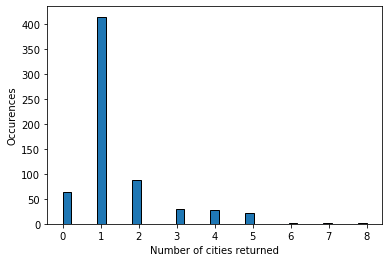

In [216]:
test = [x for x in df['City'] if len(gc.get_cities_by_name(x)) != 1 ]
num_results = [len(gc.get_cities_by_name(x)) for x in df['City']]
plt.hist(num_results, bins='auto', edgecolor='k')
plt.xlabel("Number of cities returned")
plt.ylabel("Occurences")
plt.show()

We will address this problem by defaulting to the city in the search result that has the highest population. This is a simplistic rule but probably works since the chances are higher than an event would be related to a large city and we don't really have much other information to go off of. 

## Cities with accents in the name

Our headlines don't have accents so we can't properly look up those names in geocachenames. To address this issue, we create a dictionary that maps unaccented names to the accented ones. Then we can look up the accented names to pass to the geocachename functions.

In [218]:
accented_cities = [ city['name'] for city in gc.get_cities().values() if unidecode(city['name']) != city['name']]
alternate_cityname = {unidecode(name): name for name in accented_cities}

#Test an example city known to have accents
print(f"Cordoba should be accented as {alternate_cityname['Cordoba']}")

Cordoba should be accented as Córdoba


### Create function to retrieve city info from geocachenames

In [219]:
def get_city_info(city):
    
    #Check and retrieve accented version of a city name if it has an accented version
    if city in alternate_cityname.keys():
        city = alternate_cityname[city]
    
    #Lookup city in geocachenames
    result = gc.get_cities_by_name(city)
    
    #Handle lookup results
    
    #If only 1 result returned
    if len(result) == 1:
        #Return that 1 result
        best_match = list(result[0].values())[0]
    
    #Else if more than 1 result returned
    elif len(result) > 1:
        #Return the best match by choosing the one with the biggest population
        best_match = list(max(result, key = lambda x: list(x.values())[0]['population'] ).values())[0]
    
    #Else no results were returned
    else:
        best_match = None

    #Process the result into a dictionary for output
    if best_match is not None:
        lat = best_match['latitude']
        long = best_match['longitude']
        countrycode = best_match['countrycode']
        city_info = {'Latitude':lat, "Longitude":long, "Country Code" : countrycode}
    else:
        city_info = None
    
    return(city_info)
    

In [220]:
#Test the function
get_city_info('Rio de Janeiro')

{'Latitude': -22.90642, 'Longitude': -43.18223, 'Country Code': 'BR'}

Create new the columns for latitude, longitude, and country code 

In [205]:
df['Latitude'] = df['City'].map(lambda x: get_city_info(x)['Latitude'] if get_city_info(x) else None)
df['Longitude'] = df['City'].map(lambda x: get_city_info(x)['Longitude'] if get_city_info(x) else None)
df['Country Code'] = df['City'].map(lambda x: get_city_info(x)['Country Code'] if get_city_info(x) else None)

See how many rows have no data for these new colums

In [224]:
print(f"{len(df[df['Latitude'].isnull() | df['Longitude'].isnull() | df['Country Code'].isnull()])} rows out of {len(df)} rows have no data for the new columns")

40 rows out of 650 rows have no data for the new columns


We still have over 600 rows with full location data which is sufficient per the problem description

In [226]:
df.head(20)

,Headline,City,Country,Latitude,Longitude,Country Code
0,Zika Outbreak Hits Miami,Miami,None,25.77427,-80.19366,US
1,Could Zika Reach New York City?,New York City,None,40.71427,-74.00597,US
2,First Case of Zika in Miami Beach,Miami Beach,None,25.79065,-80.13005,US
3,"Mystery Virus Spreads in Recife, Brazil",Recife,Brazil,-8.05389,-34.88111,BR
4,Dallas man comes down with case of Zika,Dallas,None,32.78306,-96.80667,US
5,Trinidad confirms first Zika case,Trinidad,None,-14.83333,-64.90000,BO
6,Zika Concerns are Spreading in Houston,Houston,None,29.76328,-95.36327,US
7,Geneve Scientists Battle to Find Cure,Geneve,None,46.20222,6.14569,CH
8,The CDC in Atlanta is Growing Worried,Atlanta,None,33.74900,-84.38798,US
9,Zika Infested Monkeys in Sao Paulo,Sao Paulo,None,-23.54750,-46.63611,BR
